In [1]:
!pip install -q pandas_ta yfinance seaborn

You should consider upgrading via the 'd:\kaushik\github repos\time_series_analysis_and_forecasting_using_neural_networks\swing_trading_strategy\env\scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
import yfinance as yf
import numpy as np
import pandas_ta as ta
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb

In [3]:
def trade_donchian(row):
    global trades, trade_open
    row = row.to_dict()

    if((trade_open==True) and (row['long'] == 1)): pass
    elif((trade_open==False) and (row['long'] == 1)):
        # open trade
        trade_open = True
        _trade = {
            'buy_date': row['next_date'],
            'buy_price': round(row['next_day_open_price']*1.005,2),
            'sell_price': None,
            'sell_date': None,
        }
        trades.append(_trade)
        del _trade
    elif((trade_open==False) and (row['short'] == 1)): pass
    elif((trade_open==True) and (row['short'] == 1)):
        # close trade
        trade_open = False
        _trade = trades[-1]
        _trade['sell_date'] = row['next_date']
        _trade['sell_price'] = round(row['next_day_open_price']*0.995,2)
        trades[-1] = _trade
        del _trade

In [4]:
def backtest(stock, period, low=20, high=20):
    global trades, trade_open
    
    data = yf.download(f'{stock}.ns', period=period, progress=False)
    
    data = data.reset_index()
    
    data[['low', 'mid', 'high']] = data.ta.donchian(lower_length=low, upper_length=high)
    
    data['long'] = ((data['Close']==data['low'])|(data['Low']==data['low'])).astype('int')
    data['short'] = ((data['Close']==data['high'])|(data['High']==data['high'])).astype('int')
    
    data['next_day_open_price'] = data['Open'].shift(-1)
    data['next_date'] = data['Date'].shift(-1).astype('string')
    
    trade_open = False
    
    trades = []
    
    data.dropna(inplace=True)
    
    cols = ['Date', 'Open', 'Close', 'Adj Close', 'Low', 'High', 'low', 'mid', 'high', 'long', 'short', 'next_day_open_price', 'next_date']
    data = data[cols]
    data.apply(trade_donchian, axis=1)

    if(len(trades)==0): return None
    x = pd.DataFrame(trades)
    
    x['buy_date'] = pd.to_datetime(x['buy_date'], format="%Y-%m-%d", dayfirst=True)
    x['sell_date'] = pd.to_datetime(x['sell_date'], format="%Y-%m-%d", dayfirst=True)
    x['returns'] = round(100*(x['sell_price']-x['buy_price'])/x['buy_price'],2)
    x['holding_period'] = (x['sell_date'] - x['buy_date']).dt.days
    x['stock'] = stock
    return x

In [5]:
TRADES = pd.DataFrame()
trades = []
trade_open = False

nifty_50_stocks = ['EICHERMOT','HEROMOTOCO','NESTLEIND','ONGC',
                   'BAJAJ-AUTO','TATASTEEL','GRASIM',
                   'BRITANNIA','BAJFINANCE','M&M','divislab',
                   'HINDUNILVR','HDFCBANK','HDFCLIFE','BHARTIARTL','TCS',
                   'LT','DRREDDY','ULTRACEMCO','SUNPHARMA','NTPC',
                   'TATAMOTORS','UPL','SBIN','HINDALCO','ITC','JSWSTEEL',
                   'COALINDIA','RELIANCE','BPCL','LTIM','MARUTI','HCLTECH',
                   'POWERGRID','WIPRO','SBILIFE','AXISBANK',
                   'ADANIPORTS','ICICIBANK','TITAN','BAJAJFINSV','KOTAKBANK',
                   'TATACONSUM','APOLLOHOSP','INFY','ASIANPAINT',
                   'ADANIENT','INDUSINDBK','TECHM','CIPLA']


for stock in nifty_50_stocks:
    _tr = backtest(stock, '10y', 20, 20)
    if(len(TRADES)==0): TRADES = _tr
    else: TRADES = pd.concat([TRADES, _tr], ignore_index=True)

In [6]:
TRADES.to_csv('trades.csv', index=False)

In [7]:
historical_trades = TRADES.dropna(how='any')

In [8]:
historical_trades[['returns', 'holding_period']].describe()

,returns,holding_period
count,1991.000000,1991.000000
mean,0.942185,37.942240
std,8.435581,27.257642
min,-68.710000,1.000000
25%,-1.670000,18.000000
50%,2.490000,31.000000
75%,5.495000,51.000000
max,31.180000,173.000000


In [9]:
historical_trades.loc[:,'pos_neg'] = (historical_trades['returns']>0).astype('int')

C:\Users\alarv\AppData\Local\Temp\ipykernel_16800\29694905.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historical_trades.loc[:,'pos_neg'] = (historical_trades['returns']>0).astype('int')


In [10]:
historical_trades['pos_neg'].value_counts(normalize=True)*100

pos_neg
1    66.248117
0    33.751883
Name: proportion, dtype: float64

In [11]:
historical_trades.groupby('pos_neg')[['returns', 'holding_period']].describe().T

# historical_trades.groupby('pos_neg')[['holding_period']].describe()

pos_neg                        0            1
returns        count  672.000000  1319.000000
               mean    -7.445238     5.215383
               std      8.717681     3.821924
               min    -68.710000     0.010000
               25%     -9.307500     2.535000
               50%     -4.630000     4.480000
               75%     -1.587500     7.145000
               max     -0.000000    31.180000
holding_period count  672.000000  1319.000000
               mean    63.135417    25.106899
               std     28.013906    15.289962
               min      1.000000     1.000000
               25%     43.000000    14.000000
               50%     58.500000    23.000000
               75%     78.000000    32.000000
               max    173.000000    97.000000

In [12]:
historical_trades.groupby('pos_neg')[['returns']].sum()

,returns
pos_neg,
0,-5003.20
1,6879.09


In [13]:
historical_trades[['returns']].sum()

returns    1875.89
dtype: float64

In [14]:
historical_trades.groupby(pd.cut(historical_trades['returns'], [-10000,-10,-5,0,5,10,15,20,10000]))[['returns', 'holding_period']].describe().T

returns               (-10000, -10]   (-10, -5]     (-5, 0]      (0, 5]  \
returns        count     153.000000  172.000000  347.000000  754.000000   
               mean      -20.084902   -7.232907   -1.977378    2.712016   
               std         9.987816    1.365290    1.409368    1.399064   
               min       -68.710000   -9.980000   -4.980000    0.010000   
               25%       -23.720000   -8.285000   -3.210000    1.530000   
               50%       -16.980000   -7.195000   -1.650000    2.825000   
               75%       -13.280000   -5.985000   -0.705000    3.900000   
               max       -10.100000   -5.000000   -0.000000    5.000000   
holding_period count     153.000000  172.000000  347.000000  754.000000   
               mean       90.235294   69.087209   48.236311   28.641910   
               std        28.356231   22.677976   18.695817   16.344048   
               min        37.000000   30.000000    1.000000    1.000000   
               25%        66.000000   51.750000   36.000000   17.000000   
               50%        86.000000   66.000000   47.000000   28.000000   
               75%       111.000000   83.000000   59.000000   36.000000   
               max       173.000000  148.000000  139.000000   97.000000   

returns                  (5, 10]    (10, 15]   (15, 20]  (20, 10000]  
returns        count  432.000000  103.000000  22.000000     8.000000  
               mean     7.048843   11.927573  16.523636    24.633750  
               std      1.351993    1.264627   1.297065     4.538681  
               min      5.010000   10.020000  15.200000    20.100000  
               25%      5.810000   10.870000  15.380000    21.160000  
               50%      6.860000   11.640000  15.950000    22.930000  
               75%      8.130000   12.985000  17.777500    27.902500  
               max     10.000000   14.420000  18.860000    31.180000  
holding_period count  432.000000  103.000000  22.000000     8.000000  
               mean    20.949074   18.961165  17.500000    16.500000  
               std     12.518096   10.516022  15.190066     9.768755  
               min      2.000000    4.000000   2.000000     6.000000  
               25%     11.750000   12.500000   8.250000     7.500000  
               50%     19.000000   17.000000  14.000000    16.000000  
               75%     28.000000   23.000000  20.000000    23.750000  
               max     76.000000   68.000000  73.000000    31.000000

C:\Users\alarv\AppData\Local\Temp\ipykernel_16800\2749105274.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


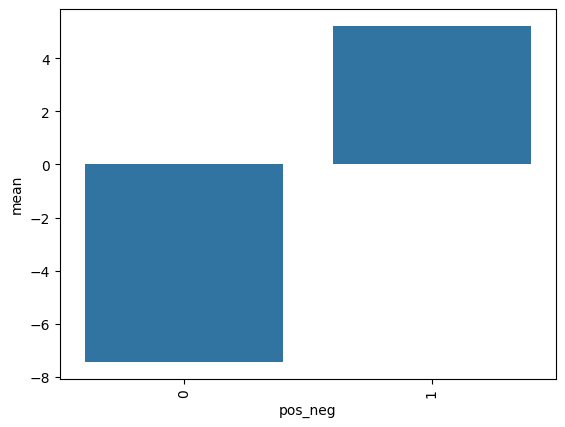

C:\Users\alarv\AppData\Local\Temp\ipykernel_16800\2749105274.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


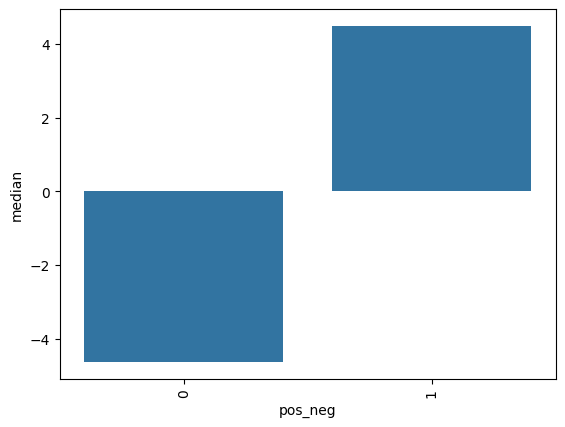

In [15]:
pos = historical_trades.groupby('pos_neg')['returns'].agg(['mean']).reset_index()
pos = pos.sort_values(by='mean', ascending=False).head(10)
ax = sb.barplot(x='pos_neg', y='mean', data=pos)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

pos = historical_trades.groupby('pos_neg')['returns'].agg(['median']).reset_index()
pos = pos.sort_values(by='median', ascending=False).head(10)
ax = sb.barplot(x='pos_neg', y='median', data=pos)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()